# Sentiment Analysis IMDB

### Libs

In [1]:
!pip install groq

In [37]:
from datasets import Dataset, load_dataset, concatenate_datasets
import os
import getpass
from groq import Groq
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from tqdm.notebook import tqdm
import pandas as pd
import string
from typing import List
import matplotlib.pyplot as plt
import seaborn as sns


GROQ_KEY = os.getenv("GROQ_KEY", getpass.getpass("Enter your Groq API key: "))
client = Groq(
    api_key=GROQ_KEY,
)
MODELS = ["llama3-70b-8192", "llama3-8b-8192", "mixtral-8x7b-32768", "gemma-7b-it"]
model = MODELS[0]

os.makedirs("results", exist_ok=True)

In [38]:
INDEX_NEGATIVE = 7408
INDEX_POSITIVE = 19908
RANGE_INDEXES = 463
FEWSHOT_SAMPLE = 50  # Need to be less INDEX_NEGATIVE and INDEX_POSITIVE

### Load Dataset

In [39]:
imdb_dataset = load_dataset("imdb")

In [40]:
train_dataset = imdb_dataset["train"]
test_dataset = imdb_dataset["test"]

In [41]:
reviews_dataset = concatenate_datasets(
    [
        train_dataset.select(
            indices=range(INDEX_NEGATIVE, INDEX_NEGATIVE + RANGE_INDEXES)
        ),
        train_dataset.select(
            indices=range(INDEX_POSITIVE, INDEX_POSITIVE + RANGE_INDEXES)
        ),
    ]
)

In [42]:
fewshot_dataset = concatenate_datasets(
    [
        train_dataset.filter(lambda x: x["label"] == 0).select(
            indices=range(FEWSHOT_SAMPLE)
        ),
        train_dataset.filter(lambda x: x["label"] == 1).select(
            indices=range(FEWSHOT_SAMPLE)
        ),
    ]
)

### Setup GROQ

In [43]:
def predict_groq(text):

    chat_completion = client.chat.completions.create(
        messages=[
            {
                "role": "user",
                "content": f"{text}",
            }
        ],
        model=model,
        seed=42,
        temperature=0,
    )

    return chat_completion.choices[0].message.content

### Setup Inference

In [78]:
# Zero-shot
def process_prompt_zs(prompt, dataset=reviews_dataset, attempts=10):
    preds = {}
    for _ in range(attempts):
        for index, review in tqdm(
            enumerate(reviews_dataset["text"]),
            total=len(reviews_dataset["text"]) - len(preds),
        ):
            try:
                if index not in preds:
                    preds[index] = predict_groq(prompt.format(text=review))
            except Exception as e:
                print(f"error processing index: {index}")
        if len(preds) == len(reviews_dataset["text"]):
            return preds
    return preds


# Zero-shot with context
def process_prompt_context(prompt, context, dataset=reviews_dataset, attempts=10):
    preds = {}
    for _ in range(attempts):
        for index, review in tqdm(
            enumerate(reviews_dataset["text"]),
            total=len(reviews_dataset["text"]) - len(preds),
        ):
            try:
                if index not in preds:
                    preds[index] = predict_groq(
                        prompt.format(text=review, context=context)
                    )
            except Exception as e:
                print(f"error processing index: {index}")
        if len(preds) == len(reviews_dataset["text"]):
            return preds
    return preds


def post_process_preds(preds: List[str]):

    # get only the first word and lowercase
    preds = list(map(lambda i: i.split()[0].lower(), preds.values()))

    # remove punctuation
    preds = list(
        map(lambda i: i.translate(str.maketrans("", "", string.punctuation)), preds)
    )

    return preds


def evaluate_preds(preds: List[str], dataset=reviews_dataset):

    y_true = reviews_dataset["label"]

    labels = {"negative": 0, "positive": 1, "mixed": 2, "missmatch": 3}
    y_pred = [labels[p] if p in labels else 3 for p in preds]

    accuracy = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average="weighted", zero_division=1)
    precision = precision_score(y_true, y_pred, average="weighted", zero_division=1)
    recall = recall_score(y_true, y_pred, average="weighted", zero_division=1)

    print(f"Accuracy: {accuracy*100:.2f}%")
    print(f"F1 Score: {f1*100:.2f}%")
    print(f"Precision: {precision*100:.2f}%")
    print(f"Recall: {recall*100:.2f}%")

    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(labels))))

    # Plot
    plt.figure(figsize=(8, 6))
    sns.set(font_scale=1.4)  # Adjust font size
    sns.heatmap(
        cm,
        annot=True,
        fmt="g",
        cmap="Blues",
        xticklabels=["Negative", "Positive", "Mixed", "Missmatch"],
        yticklabels=["Negative", "Positive", "Mixed", "Missmatch"],
    )
    plt.xlabel("Predicted Values")
    plt.ylabel("Actual Values")
    plt.title("Confusion Matrix")
    plt.show()

    return [accuracy, f1, precision, recall, cm]

### Zero-shot

In [45]:
from huggingface_hub import login

login()

In [174]:
from transformers import AutoTokenizer, AutoConfig

tokenizer = AutoTokenizer.from_pretrained("meta-llama/Meta-Llama-3-70B")
config = AutoConfig.from_pretrained("meta-llama/Meta-Llama-3-70B")

context_size = config.max_position_embeddings


def format_prompt(prompt, special_tokens=False):
    if special_tokens:
        return tokenizer.decode(tokenizer(prompt)["input_ids"])
    return prompt

### Prompt 1

Zero-shot.

- Accuracy: 93.52%
- F1 Score: 93.98%
- Precision: 94.48%
- Recall: 93.52%

In [175]:
prompt = "Your task is to classify sentences sentiment as 'positive' or 'negative'. The only valid answers are 'positive' or 'negative'.\n\
Sentence: {text}\nAnswer:"

prompt = format_prompt(prompt)

print(prompt)

Your task is to classify sentences sentiment as 'positive' or 'negative'. The only valid answers are 'positive' or 'negative'.
Sentence: {text}
Answer:


In [176]:
preds = process_prompt_zs(prompt)

if len(preds) != len(reviews_dataset["text"]):
    print("Some reviews were not processed.")
else:
    print("All reviews processed.")
    preds = post_process_preds(preds)

  0%|          | 0/926 [00:00<?, ?it/s]

All reviews processed.


Accuracy: 93.95%
F1 Score: 94.51%
Precision: 95.10%
Recall: 93.95%


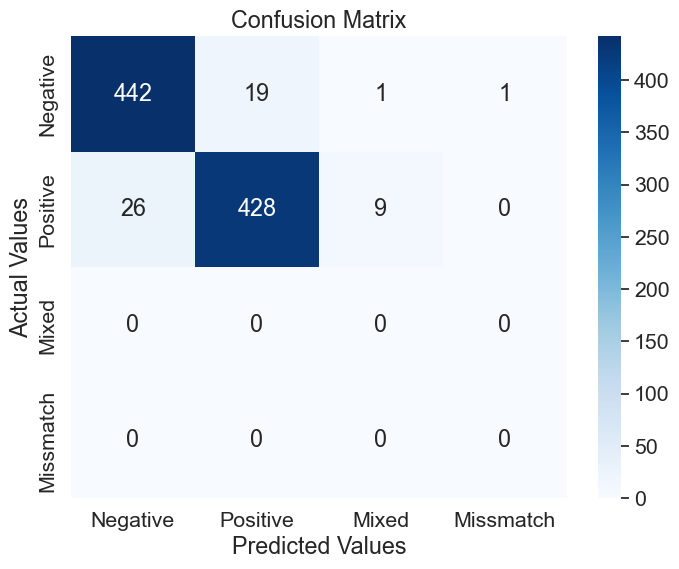

In [177]:
metrics = evaluate_preds(preds)

In [178]:
# save predictions
pd.DataFrame(preds, columns=["predictions"]).to_csv(
    "results/prompt_zs.csv", index=False
)

# save metrics
pd.DataFrame(metrics, columns=["metrics"]).to_csv(
    "results/prompt_zs_metrics.csv", index=False
)

### Prompt 2

Extract context of few-shot using the model and add in prediction.

In [179]:
prompt_context = "Your task it's extract the general context about the sentences to understand what they are talking about and what they have in common. That will be used in other prompts to improve classification predictions, Answer directly the context, be concise.\n\
Sentences:\n\
{sentences}\n\
Answer: "

prompt_context = format_prompt(prompt_context)

print(prompt_context)

Your task it's extract the general context about the sentences to understand what they are talking about and what they have in common. That will be used in other prompts to improve classification predictions, Answer directly the context, be concise.
Sentences:
{sentences}
Answer: 


#### 5 Examples Attempt

The result dont express the general context about the data.

In [180]:
sentences = "\n".join(
    [f"{i} - {text}" for i, text in enumerate(fewshot_dataset["text"][:5])]
)

In [181]:
print(prompt_context.format(sentences=sentences), "\n")
print(
    f"Number of tokens: {len(tokenizer(prompt_context.format(sentences=sentences))['input_ids'])}"
)

Your task it's extract the general context about the sentences to understand what they are talking about and what they have in common. That will be used in other prompts to improve classification predictions, Answer directly the context, be concise.
Sentences:
0 - I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm abo

In [182]:
context = predict_groq(prompt_context.format(sentences=sentences))
context

'The general context of these sentences is about the 1967 Swedish film "I Am Curious-Yellow" and its reception, controversy, and criticism.'

#### 10 Examples Attempt

The results appears to be good.

In [183]:
sentences = "\n".join(
    [f"{i} - {text}" for i, text in enumerate(fewshot_dataset["text"][:10])]
)

In [184]:
print(prompt_context.format(sentences=sentences), "\n")
print(
    f"Number of tokens: {len(tokenizer(prompt_context.format(sentences=sentences))['input_ids'])}"
)

Your task it's extract the general context about the sentences to understand what they are talking about and what they have in common. That will be used in other prompts to improve classification predictions, Answer directly the context, be concise.
Sentences:
0 - I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm abo

In [185]:
context = predict_groq(prompt_context.format(sentences=sentences))
context

'The general context of these sentences is that they are all movie reviews, with the majority of them being negative reviews. The reviewers are criticizing the films, calling them boring, pretentious, and unwatchable, with some even calling them "trash" or "a waste of time". The reviews are discussing the films\' plots, acting, direction, and overall quality, with many reviewers expressing disappointment and frustration with the films.'

#### Prompt processing

In [186]:
prompt = "Your task is to classify sentences sentiment as 'positive' or 'negative', the context will provide the background about the sentence. The only valid answers are 'positive' or 'negative'.\n\
Context: {context}\n\
Sentence: {text}\n\
Answer: "

prompt = format_prompt(prompt)

In [187]:
print("Example:\n", prompt.format(context=context, text=fewshot_dataset["text"][0]))

Example:
 Your task is to classify sentences sentiment as 'positive' or 'negative', the context will provide the background about the sentence. The only valid answers are 'positive' or 'negative'.
Context: The general context of these sentences is that they are all movie reviews, with the majority of them being negative reviews. The reviewers are criticizing the films, calling them boring, pretentious, and unwatchable, with some even calling them "trash" or "a waste of time". The reviews are discussing the films' plots, acting, direction, and overall quality, with many reviewers expressing disappointment and frustration with the films.
Sentence: I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot

In [188]:
preds = process_prompt_context(prompt, context)

if len(preds) != len(reviews_dataset["text"]):
    print("Some reviews were not processed.")
else:
    print("All reviews processed.")
    preds = post_process_preds(preds)

  0%|          | 0/926 [00:00<?, ?it/s]

All reviews processed.


Accuracy: 94.60%
F1 Score: 94.80%
Precision: 95.02%
Recall: 94.60%


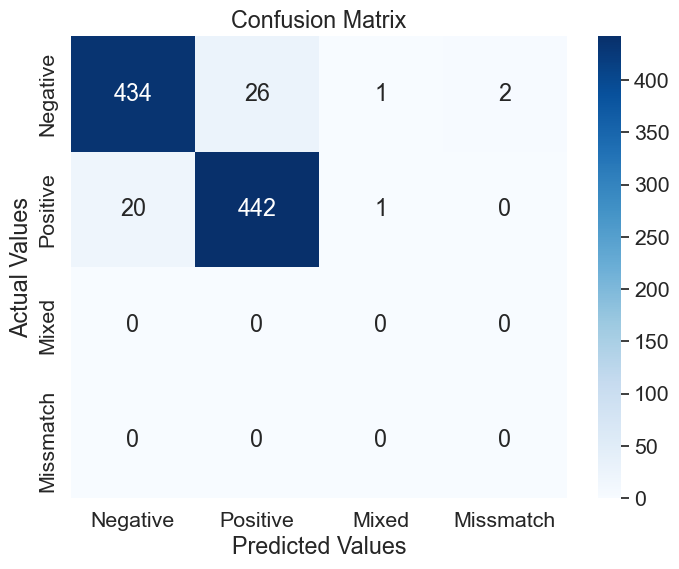

In [189]:
metrics = evaluate_preds(preds)

In [190]:
# save predictions
pd.DataFrame(preds, columns=["predictions"]).to_csv(
    "results/prompt_context.csv", index=False
)

# save metrics
pd.DataFrame(metrics, columns=["metrics"]).to_csv(
    "results/prompt_context_metrics.csv", index=False
)